<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_graph_modelling_language_using_select_speaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Graph Modeling Language with using select_speaker

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is about using graphs to define the transition paths amongst speakers.

Benefits
- This contribution fills the gap between the current modes of GroupChat Class (auto, manual, round_robin) and an expressive directed graph. See Motivation for more detailed discussion.


## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
%%capture --no-stderr
# %pip install pyautogen~=0.2.0b6
%pip install networkX~=3.2.1
%pip install matplotlib~=3.8.1

In [2]:
import autogen
import networkx as nx
import matplotlib.pyplot as plt
from autogen.agentchat.groupchat import GroupChat
from autogen.agentchat.assistant_agent import AssistantAgent

import random
from typing import List, Dict

print(autogen.__version__)

0.2.0b6


## Motivation


The current GroupChat class allows transition to any agent (without or without the decision of LLM), some use case might demand for more control over transition. A graph is a possible way to control the transition paths, where each node represents an agent and each directed edge represent possible transition path. Let's illustrate the current transition paths for a GroupChat with five agents.

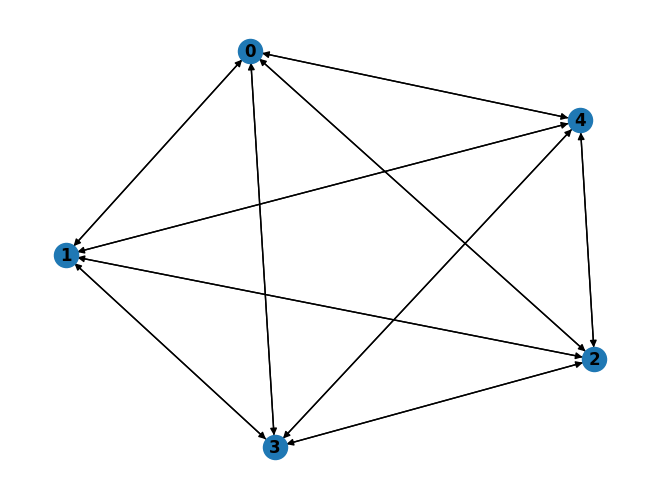

In [3]:
# Create an empty directed graph
graph = nx.DiGraph()

# Add 5 nodes to the graph using a for loop
for node_id in range(5):
    graph.add_node(node_id, label=str(node_id))

# Add edges between all nodes using a nested for loop
for source_node in range(5):
    for target_node in range(5):
        if source_node != target_node:  # To avoid self-loops
            graph.add_edge(source_node, target_node)

nx.draw(graph, with_labels=True, font_weight='bold')

### Possibly interesting transition paths

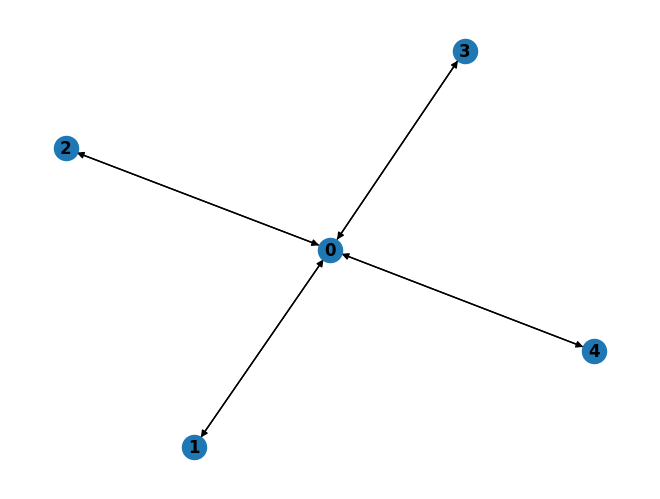

In [4]:

# Hub and Spoke
# Create an empty directed graph
graph = nx.DiGraph()

# Add 5 nodes to the graph using a for loop
for node_id in range(5):
    graph.add_node(node_id, label=str(node_id))

# Add edges between all nodes using a nested for loop
for source_node in range(5):
    target_node = 0
    if source_node != target_node:  # To avoid self-loops
        graph.add_edge(source_node, target_node)
        graph.add_edge(target_node, source_node)


nx.draw(graph, with_labels=True, font_weight='bold')

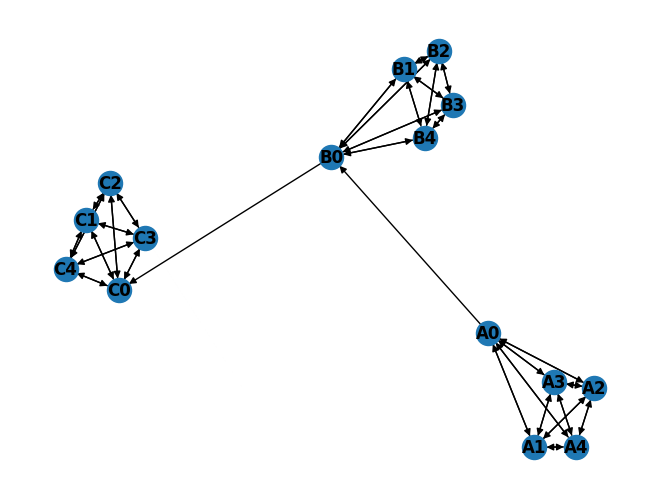

In [5]:
# Sequential Team Operations
# Create an empty directed graph
graph = nx.DiGraph()

# Outer loop for prefixes 'A', 'B', 'C'
for prefix in ['A', 'B', 'C']:
    # Add 5 nodes with each prefix to the graph using a for loop
    for i in range(5):
        node_id = f"{prefix}{i}"
        graph.add_node(node_id, label=node_id)

    # Add edges between nodes with the same prefix using a nested for loop
    for source_node in range(5):
        source_id = f"{prefix}{source_node}"
        for target_node in range(5):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # To avoid self-loops
                graph.add_edge(source_id, target_id)
                
graph.add_edge('A0', 'B0')
graph.add_edge('B0', 'C0')

# Draw the graph
nx.draw(graph, with_labels=True, font_weight='bold')

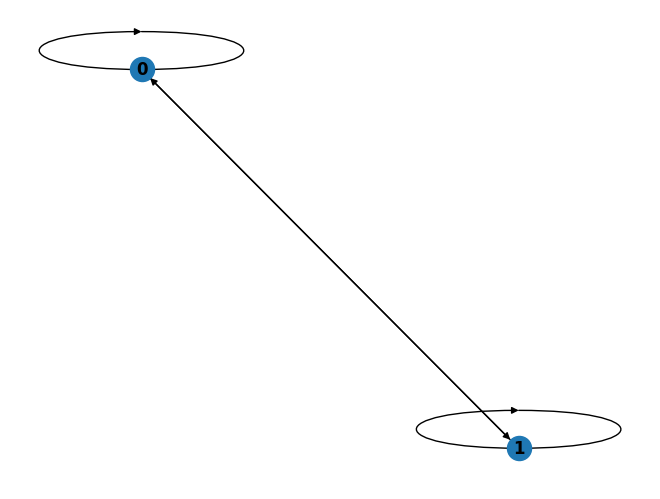

In [6]:
# Think aloud and debate
graph = nx.DiGraph()

for source_node in range(2):
    graph.add_node(source_node, label=source_node)

# Add edges between nodes with the same prefix using a nested for loop
for source_node in range(2):
    for target_node in range(2):
        graph.add_edge(source_node, target_node)

nx.draw(graph, with_labels=True, font_weight='bold')
        

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [11]:
# The default config list in notebook.
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

#config_list_gpt4 = autogen.config_list_from_json("OAI_CONFIG_LIST",filter_dict={"model": ["gpt-4-1106-preview"],},)

if (config_list_gpt4[0].get('api_type') is not None):
    # Pop api_type
    config_list_gpt4[0].pop('api_type')

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choosing "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Demonstration

### Team Operations


In [8]:
# Termination message detection
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False

# Terminates the conversation when TERMINATE is detected.
user_proxy = autogen.UserProxyAgent(
        name="User_proxy",
        system_message="Terminator admin.",
        code_execution_config=False,
        is_termination_msg=is_termination_msg,
        human_input_mode="NEVER")

agents = [user_proxy]


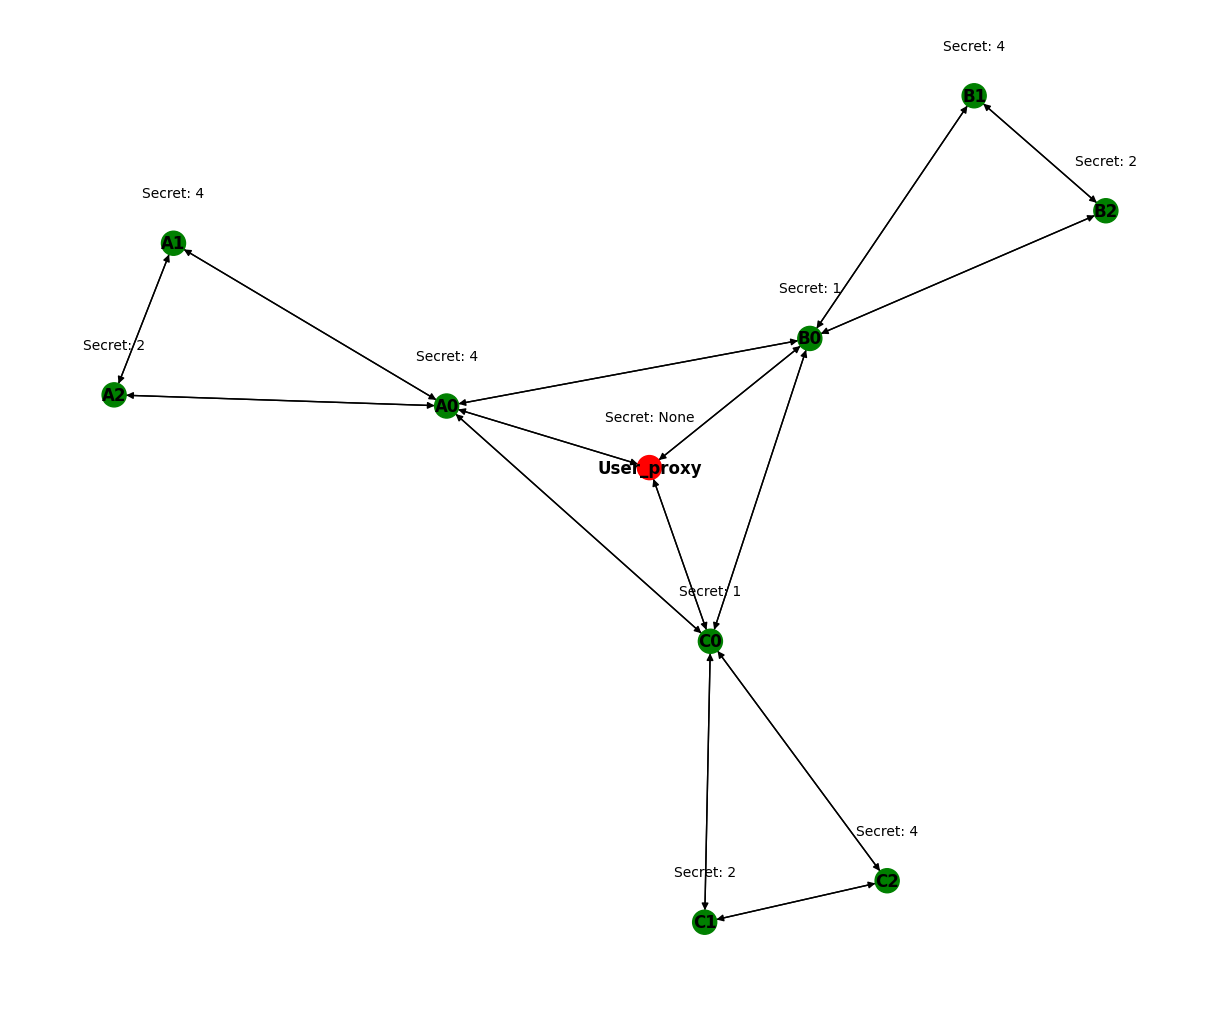

In [9]:
# llm config
llm_config = {"config_list": config_list_gpt4, "cache_seed": 100} 

# Create an empty directed graph
graph = nx.DiGraph()

# Add user_proxy node
graph.add_node(user_proxy.name, label=user_proxy.name, secret_value=None)


# Outer loop for prefixes 'A', 'B', 'C'
for prefix in ['A', 'B', 'C']:
    # Add 3 nodes with each prefix to the graph using a for loop
    for i in range(3):
        node_id = f"{prefix}{i}"
        secret_value = random.randint(1, 5)  # Generate a random secret value
        graph.add_node(node_id, label=node_id, secret_value=secret_value)
        
        # Create an AssistantAgent for each node (assuming AssistantAgent is a defined class)
        agents.append(AssistantAgent(name=node_id, 
                       system_message=f"""Your name is {node_id}. 
                                          Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.
                                          
                                          You have {secret_value} chocolates.
                                          
                                          The list of players are [A0, A1, A2, B0, B1, B2, C0, C1, C2].
                                          
                                            Your first character of your name is your team, and your second character denotes that you are a team leader if it is 0. 
                                            CONSTRAINTS: Team members can only talk within the team, whilst team leader can talk to team leaders of other teams but not team members of other teams.
                                            
                                            You can use NEXT: to suggest the next speaker. You have to respect the CONSTRAINTS, and can only suggest one player from the list of players, i.e., do not suggest A3 because A3 is not from the list of players.
                                            Team leaders must make sure that they know the sum of the individual chocolate count of all three players in their own team, i.e., A0 is responsible for team A only.
                                            
                                          Keep track of the player's tally using a JSON format so that others can check the total tally. Use
                                          A0:?, A1:?, A2:?,
                                          B0:?, B1:?, B2:?,
                                          C0:?, C1:?, C2:?
              
                                          If you are the team leader, you should aggregate your team's total chocolate count to cooperate.
                                          Once the team leader know their team's tally, they can suggest another team leader for them to find their team tally, because we need all three team tallys to succeed.
                                          Use NEXT: to sugest the next speaker, e.g., NEXT: A0.
                                          
                                          Once we have the total tally from all nine players, sum up all three teams' tally, then terminate the discussion using TERMINATE.
                                          
                                          """,
                       llm_config=llm_config))

    # Add edges between nodes with the same prefix using a nested for loop
    for source_node in range(3):
        source_id = f"{prefix}{source_node}"
        for target_node in range(3):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # To avoid self-loops
                graph.add_edge(source_id, target_id)

# Adding edges between teams
graph.add_edge('A0', 'B0')
graph.add_edge('A0', 'C0')
graph.add_edge('B0', 'A0')
graph.add_edge('B0', 'C0')
graph.add_edge('C0', 'A0')
graph.add_edge('C0', 'B0')

# Connecting team lead to User_proxy and vice versa
graph.add_edge('A0', 'User_proxy')
graph.add_edge('B0', 'User_proxy')
graph.add_edge('C0', 'User_proxy')
graph.add_edge('User_proxy', 'A0')
graph.add_edge('User_proxy', 'B0')
graph.add_edge('User_proxy', 'C0')

# Updating node User_proxy
graph.nodes['User_proxy']['first_round_speaker'] = True

def get_node_color(node):
    if graph.nodes[node].get('first_round_speaker', False):
        return 'red'
    else:
        return 'green'

# Draw the graph with secret values annotated
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph)  # positions for all nodes

# Draw nodes with their colors
nx.draw(graph, pos, with_labels=True, font_weight='bold', node_color=[get_node_color(node) for node in graph])

# Annotate secret values
for node, (x, y) in pos.items():
    secret_value = graph.nodes[node]['secret_value']
    plt.text(x, y + 0.1, s=f"Secret: {secret_value}", horizontalalignment='center')

plt.show()

## Implementation

In [10]:
from autogen.agentchat.contrib.graphgroupchat import GraphGroupChat

graph_group_chat = GraphGroupChat(
    agents=agents,  # Include all agents
    messages=[],
    max_round=20,
    graph=graph
)


# Create the manager
manager = autogen.GroupChatManager(groupchat=graph_group_chat, llm_config=llm_config)


# Initiates the chat with Alice
agents[0].initiate_chat(manager, message="""
                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader. 
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team A leader. 
                        NEXT: A0""")



User_proxy (to chat_manager):


                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader. 
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team A leader. 
                        NEXT: A0

--------------------------------------------------------------------------------
A0 (to chat_manager):

As the team leader of Team A, my task is to gather the total chocolate count of my team. My individual count is 4 chocolates. I'll need to check with A1 and A2 for their counts.

Before checking with my teammates, the tally is as follows:

```
A0:4, A1:?, A2:?,
B0:?, B1:?, B2:?,
C0:?, C1:?, C2:?
```

Now, let's see how many chocolates A1 has.
NEXT: A1

--------------------------------------------------------------------------------
A1 (to chat_manager):

I am A1, and I have 4 chocolates. 

Updating the tally for Team A with my cou